In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType
from pyspark.sql.types import StructType, StructField, TimestampType, DateType, StringType
from pyspark.sql.functions import col, trim
from pyspark.sql.functions import unix_timestamp, current_timestamp
from pyspark.sql.functions import lit
from pyspark.sql.functions import when
import seaborn as sb
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import matplotlib.pyplot as plt

# Q1

In [4]:
directory = '/Users/janbol/Documents/Career Documents/Carnegie Mellon University/CMU Courses/14-763 - Systems and Toolchains for AI Engineers/Week 4/HW 4/NSL-KDD/KDDTrain+.txt'
jdbc_jar_path = "/Users/janbol/Downloads/postgresql-42.7.4.jar"  

appName = "HW4"
master = "local"

conf = pyspark.SparkConf() \
    .set('spark.driver.host', '127.0.0.1') \
    .setAppName(appName) \
    .setMaster(master) \
    .set("spark.jars", jdbc_jar_path)

sc = SparkContext.getOrCreate(conf=conf)
sqlContext = SQLContext(sc)

spark = sqlContext.sparkSession.builder.getOrCreate()


# Loading data from csv to a dataframe on a local machine. 
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","classes","difficulty_level"]

df = spark.read.csv(directory,header=False, inferSchema= True).toDF(*col_names)


unique = df.select("protocol_type").distinct()
two_columns = df.select("protocol_type", "logged_in")

tcp_type = two_columns.filter(two_columns["protocol_type"] == "tcp")
udp_type = two_columns.filter(two_columns["protocol_type"] == "udp")
icmp_type = two_columns.filter(two_columns["protocol_type"] == "icmp")

tcp_in = tcp_type.filter(tcp_type["logged_in"]==1).count()
tcp_non = tcp_type.filter(tcp_type["logged_in"]==0).count()

udp_in = udp_type.filter(udp_type["logged_in"]==1).count()
udp_non= udp_type.filter(udp_type["logged_in"]==0).count()

icmp_in = icmp_type.filter(icmp_type["logged_in"]==1).count()
icmp_non = icmp_type.filter(icmp_type["logged_in"]==0).count()

ins_and_nons = spark.createDataFrame(
    [("tcp", tcp_in, tcp_non), ("udp", udp_in,udp_non), ("icmp", icmp_in,icmp_non)], 
    ["protocol_type", "logged_in_count", "non_logged_in_count"])

ins_and_nons.show()

+-------------+---------------+-------------------+
|protocol_type|logged_in_count|non_logged_in_count|
+-------------+---------------+-------------------+
|          tcp|          49852|              52837|
|          udp|              0|              14993|
|         icmp|              0|               8291|
+-------------+---------------+-------------------+



24/10/02 21:04:18 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


# Q2, showing the disctinct and unique values in the column `protocol_type` after setting all the `protocol_type` to tcp for `classes` that are `normal`.

In [6]:
#Creating new dataframe so as not to mix the data with the previous DataFrame
df2 = spark.read.csv(directory,header=False, inferSchema= True).toDF(*col_names)
#Filtering for normal traffic under classes column
filtered = df2.filter(df2["classes"]=="normal") 

#After getting Dataframe with the normal traffic rows under classes column, I changed all the rows under protocol_type column to "tcp"
filtered = filtered.withColumn('protocol_type', lit("tcp"))

#Showing that only distincs value is tcp, confirming the change
filtered.select("protocol_type").distinct().show()

+-------------+
|protocol_type|
+-------------+
|          tcp|
+-------------+



# Q2, Showing the sample output in which `protocol_type` was changed to `tcp`

In [7]:
# The classes are normal and the protocol_type is "tcp"
filtered.show(7, vertical = True)

-RECORD 0-------------------------------
 duration                    | 0        
 protocol_type               | tcp      
 service                     | ftp_data 
 flag                        | SF       
 src_bytes                   | 491      
 dst_bytes                   | 0        
 land                        | 0        
 wrong_fragment              | 0        
 urgent                      | 0        
 hot                         | 0        
 num_failed_logins           | 0        
 logged_in                   | 0        
 num_compromised             | 0        
 root_shell                  | 0        
 su_attempted                | 0        
 num_root                    | 0        
 num_file_creations          | 0        
 num_shells                  | 0        
 num_access_files            | 0        
 num_outbound_cmds           | 0        
 is_host_login               | 0        
 is_guest_login              | 0        
 count                       | 2        
 srv_count      

24/10/02 20:38:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# For Question 3 please check the `HW4_Cloud` jupyter notebook file and provided screenshots.

# Q4

In [8]:
#CREATING SPARK DATAFRAME FOR KDDTest+.txt TO UPLOAD TO POSTGRES
jdbc_jar_path = "/Users/janbol/Downloads/postgresql-42.7.4.jar"  
# NOTE I had trouble finding the spark installation directory. After talking to Dr.Farag, I was recommended to use this method.
directory = '/Users/janbol/Documents/Career Documents/Carnegie Mellon University/CMU Courses/14-763 - Systems and Toolchains for AI Engineers/Week 4/HW 4/NSL-KDD/KDDTest+.txt'

appName = "HW4"
master = "local"

conf = pyspark.SparkConf() \
    .set('spark.driver.host', '127.0.0.1') \
    .setAppName(appName) \
    .setMaster(master) \
    .set("spark.jars", jdbc_jar_path)

sc = SparkContext.getOrCreate(conf=conf)
sqlContext = SQLContext(sc)

spark = sqlContext.sparkSession.builder.getOrCreate()


col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","classes","difficulty_level"]

df_test = spark.read.csv(directory,header=False, inferSchema= True).toDF(*col_names)

#Adding the columns with new column for indicating the dataset type
df_test = df_test.withColumn("dataset_type", lit("testing set"))
df_training = df.withColumn("dataset_type", lit("training set"))

df_test.count()

22544

In [7]:
#Uploading the dataframe of training data to Postgres database
df_training.write.format("jdbc") \
    .mode("overwrite") \
    .option("url", "jdbc:postgresql://localhost:5432/postgres") \
    .option("dbtable", "assignment.question4") \
    .option("user", "postgres") \
    .option("password", "your_password") \
    .option("driver", "org.postgresql.Driver") \
    .save()

In [8]:
#Uploading the dataframe of testing data to Postgres database
df_test.write.format("jdbc") \
    .mode("append") \
    .option("url", "jdbc:postgresql://localhost:5432/postgres") \
    .option("dbtable", "assignment.question4") \
    .option("user", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .save()

# Q4, showing the sample output of Postgres data that was uploaded. Both training set and testing set samples are shown. I have also provided extra screenshot taken from pgadmin4 output on `q4.png`. 

In [9]:
#pulling or reading the data from the Postgres database
pull = sqlContext.read.format("jdbc")\
	.option("url", "jdbc:postgresql://localhost:5432/postgres") \
    .option("dbtable", "assignment.question4") \
    .option("user", "postgres") \
    .option("driver", "org.postgresql.Driver") \
	.load()

In [10]:
#Showing the sample output for Training set from Postgres table
pull.filter(pull["dataset_type"] == "training set").show(5, vertical=True)

-RECORD 0-----------------------------------
 duration                    | 0            
 protocol_type               | tcp          
 service                     | ftp_data     
 flag                        | SF           
 src_bytes                   | 491          
 dst_bytes                   | 0            
 land                        | 0            
 wrong_fragment              | 0            
 urgent                      | 0            
 hot                         | 0            
 num_failed_logins           | 0            
 logged_in                   | 0            
 num_compromised             | 0            
 root_shell                  | 0            
 su_attempted                | 0            
 num_root                    | 0            
 num_file_creations          | 0            
 num_shells                  | 0            
 num_access_files            | 0            
 num_outbound_cmds           | 0            
 is_host_login               | 0            
 is_guest_

In [11]:
#Showing the sample output for Testing set from Postgres table
pull.filter(pull["dataset_type"] == "testing set").show(5, vertical=True)

-RECORD 0----------------------------------
 duration                    | 0           
 protocol_type               | tcp         
 service                     | private     
 flag                        | REJ         
 src_bytes                   | 0           
 dst_bytes                   | 0           
 land                        | 0           
 wrong_fragment              | 0           
 urgent                      | 0           
 hot                         | 0           
 num_failed_logins           | 0           
 logged_in                   | 0           
 num_compromised             | 0           
 root_shell                  | 0           
 su_attempted                | 0           
 num_root                    | 0           
 num_file_creations          | 0           
 num_shells                  | 0           
 num_access_files            | 0           
 num_outbound_cmds           | 0           
 is_host_login               | 0           
 is_guest_login              | 0

# Q5

# 1. PHASE - I

In [348]:
directory = '/Users/janbol/Documents/Career Documents/Carnegie Mellon University/CMU Courses/14-763 - Systems and Toolchains for AI Engineers/Week 4/HW 4/plays.csv'
jdbc_jar_path = "/Users/janbol/Downloads/postgresql-42.7.4.jar"  


appName = "HW4"
master = "local"

conf = pyspark.SparkConf() \
    .set('spark.driver.host', '127.0.0.1') \
    .setAppName(appName) \
    .setMaster(master) \
    .set("spark.jars", jdbc_jar_path)

sc = SparkContext.getOrCreate(conf=conf)
sqlContext = SQLContext(sc)

spark = sqlContext.sparkSession.builder.getOrCreate()

col_names = ['gameId',
 'playId',
 'quarter',
 'GameClock',
 'down',
 'yardsToGo',
 'possessionTeam',
 'yardlineSide',
 'yardlineNumber',
 'offenseFormation',
 'personnel.offense',
 'defendersInTheBox',
 'numberOfPassRushers',
 'personnel.defense',
 'HomeScoreBeforePlay',
 'VisitorScoreBeforePlay',
 'HomeScoreAfterPlay',
 'VisitorScoreAfterPlay',
 'isPenalty',
 'isSTPlay',
 'SpecialTeamsPlayType',
 'KickReturnYardage',
 'PassLength',
 'PassResult',
 'YardsAfterCatch',
 'PlayResult',
 'playDescription']
#Setting the StructType based the on the data in the columns, so that Spark will handle it appropriately.
schema = StructType([
    StructField("gameId", IntegerType(), True),
    StructField("playId", IntegerType(), True),
    StructField("quarter", IntegerType(), True),
    StructField("GameClock", TimestampType(), True),
    StructField("down", IntegerType(), True),
    StructField("yardsToGo", IntegerType(), True),
    StructField("possessionTeam", StringType(), True),
    StructField("yardlineSide", StringType(), True),
    StructField("yardlineNumber", IntegerType(), True),
    StructField("offenseFormation", StringType(), True),
    StructField("personnel.offense", StringType(), True),
    StructField("defendersInTheBox", IntegerType(), True),
    StructField("numberOfPassRushers", IntegerType(), True),
    StructField("personnel.defense", StringType(), True),
    StructField("HomeScoreBeforePlay", IntegerType(), True),
    StructField("VisitorScoreBeforePlay", IntegerType(), True),
    StructField("HomeScoreAfterPlay", IntegerType(), True),
    StructField("VisitorScoreAfterPlay", IntegerType(), True),
    StructField("isPenalty", StringType(), True),
    StructField("isSTPlay", StringType(), True),
    StructField("SpecialTeamsPlayType", StringType(), True),
    StructField("KickReturnYardage", IntegerType(), True),
    StructField("PassLength", IntegerType(), True),
    StructField("PassResult", StringType(), True),
    StructField("YardsAfterCatch", IntegerType(), True),
    StructField("PlayResult", IntegerType(), True),
    StructField("playDescription", StringType(), True)])


#Read the plays.csv file onto Spark Dataframe
plays_df = spark.read.csv(directory, header=True, schema=schema).toDF(*col_names)
#Changing the column names since the column includes unacceptable sign. Replaced the dot with a underscore.
plays_df = plays_df.withColumnRenamed("personnel.offense", "personnel_offense") \
                   .withColumnRenamed("personnel.defense", "personnel_defense")


/opt/anaconda3/envs/VENV_Apache/lib/python3.8/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [349]:
#Printing the columns to make sure everything is in order
list = plays_df.columns
list

['gameId',
 'playId',
 'quarter',
 'GameClock',
 'down',
 'yardsToGo',
 'possessionTeam',
 'yardlineSide',
 'yardlineNumber',
 'offenseFormation',
 'personnel_offense',
 'defendersInTheBox',
 'numberOfPassRushers',
 'personnel_defense',
 'HomeScoreBeforePlay',
 'VisitorScoreBeforePlay',
 'HomeScoreAfterPlay',
 'VisitorScoreAfterPlay',
 'isPenalty',
 'isSTPlay',
 'SpecialTeamsPlayType',
 'KickReturnYardage',
 'PassLength',
 'PassResult',
 'YardsAfterCatch',
 'PlayResult',
 'playDescription']

In [350]:
#To start the data engineering process, checking the NA values for each column.
for column in list:
    empty_count = plays_df.filter(col(column) == "NA").count()
    if empty_count != 0:
        print(f"for column : {column}, there are {empty_count} NA cells")

for column : yardlineSide, there are 180 NA cells
for column : offenseFormation, there are 2773 NA cells
for column : personnel_offense, there are 2625 NA cells
for column : personnel_defense, there are 2625 NA cells
for column : SpecialTeamsPlayType, there are 11557 NA cells
for column : PassResult, there are 7230 NA cells


In [351]:
#To start the data engineering process, checking the Null values for each column.
for column in list:
    empty_count = plays_df.filter(col(column).isNull()).count()
    if empty_count != 0:
        print(f"for column : {column}, there are {empty_count} Null cells")

for column : yardlineNumber, there are 180 Null cells
for column : defendersInTheBox, there are 2637 Null cells
for column : numberOfPassRushers, there are 7483 Null cells
for column : KickReturnYardage, there are 13489 Null cells
for column : PassLength, there are 7932 Null cells
for column : YardsAfterCatch, there are 10256 Null cells


In [352]:
#Starting yardlineNumber and checking the percentage of Null values
yardlineNumber_count = plays_df.select("yardlineNumber").count()
pct = 180/yardlineNumber_count
pct*100

1.2682308180088777

In [353]:
#Dropping the Description column as it cannot be process by ML model
plays_df = plays_df.drop("playDescription")

In [354]:
#Getting rid of NA rows in the yardlineSide column, and by extension the such rows in yardlineNumber
#Because when there is NA in yardlineSide row, there is also NA in yardlineNumber
#The rows that have NA will be dropped because the percentage is fairly low, just above 1%. Should be safe to drop.
#Same case for the yardlineNumber!
plays_df = plays_df.filter(plays_df["yardlineSide"] != "NA")

In [355]:
#Making sure that yardlineSide has been fixed, and the result shows there is no Null values in yardlineSide
#This also means the values in yardlineNumber, should be fixed. 
for column in list:
    empty_count = plays_df.filter(col(column).isNull()).count()
    if empty_count != 0:
        print(f"for column : {column}, there are {empty_count} Null cells")

for column : defendersInTheBox, there are 2622 Null cells
for column : numberOfPassRushers, there are 7408 Null cells
for column : KickReturnYardage, there are 13315 Null cells
for column : PassLength, there are 7849 Null cells
for column : YardsAfterCatch, there are 10138 Null cells


In [356]:
#Now there are 5 more columns to work with. 
#As for the defendersInTheBox, the Null values are being replaced with 0
#Since there are special play types that require no defenders in the box. 
#Null value makes sense here since there are no defenders and in other play types there will be defenders.
#This is a valuable information that shouldn't be dropped or imputated.
plays_df = plays_df.withColumn("defendersInTheBox", when(plays_df["defendersInTheBox"].isNull(), 0).otherwise(plays_df["defendersInTheBox"]))
#https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.when.html
#https://medium.com/sparkbyexamples/spark-case-when-and-when-otherwise-usage-spark-by-examples-e82259d62f91

In [357]:
#After getting replacing the null with zero, again checking what is left to fix. 
for column in list:
    empty_count = plays_df.filter(col(column).isNull()).count()
    if empty_count != 0:
        print(f"for column : {column}, there are {empty_count} Null cells")

for column : numberOfPassRushers, there are 7408 Null cells
for column : KickReturnYardage, there are 13315 Null cells
for column : PassLength, there are 7849 Null cells
for column : YardsAfterCatch, there are 10138 Null cells


In [358]:
#Although the percentage is a bit high for the numberOfPassRushers
#depending on the defence types the number of pass rushers change which can be helpful in predicting the PlayResult.
#It also provides additional context for Pass result. 
#it also helps with indicating which team is on offense and defence.
numberOfPassRushers_count = plays_df.select("numberOfPassRushers").count()
pct = 7408/numberOfPassRushers_count
pct*100

52.86519660315422

In [359]:
#As a result it is better to keep the data and replace the Nulls with zeros. 
#because it makes sense to have no pass rushers when you are in offensive
plays_df = plays_df.withColumn("numberOfPassRushers", when(plays_df["numberOfPassRushers"].isNull(), 0).otherwise(plays_df["numberOfPassRushers"]))

In [360]:
#Checking again the Null values left
for column in list:
    empty_count = plays_df.filter(col(column).isNull()).count()
    if empty_count != 0:
        print(f"for column : {column}, there are {empty_count} Null cells")

for column : KickReturnYardage, there are 13315 Null cells
for column : PassLength, there are 7849 Null cells
for column : YardsAfterCatch, there are 10138 Null cells


In [361]:
#Kickreturn yardage has a high percentage of Nulls
KickReturnYardage_count = plays_df.select("KickReturnYardage").count()
pct = 10138/KickReturnYardage_count
pct*100

72.34710625847427

In [362]:
#Given the percentage, it is tempting to drop the column
#But it also provides good numbers for predicting the Playresult
#since during kickoff, punts, and other special play types it will be very useful number in predicting the Playresult
#If this column is dropped, the prediction accuracy will drop since there will be no columns 
#that will be closely associated with Playresult for special play types
plays_df = plays_df.withColumn("KickReturnYardage", when(plays_df["KickReturnYardage"].isNull(), 0).otherwise(plays_df["KickReturnYardage"]))

In [363]:
#Checking again the Null values left
for column in list:
    empty_count = plays_df.filter(col(column).isNull()).count()
    if empty_count != 0:
        print(f"for column : {column}, there are {empty_count} Null cells")

for column : PassLength, there are 7849 Null cells
for column : YardsAfterCatch, there are 10138 Null cells


In [364]:
#Again these two are even more important when in comes to predicting the PlayResult
#many of the PlayReults can be estimated by adding these two column
#Making the values to zero will not hurt the data as Pass result gives context
#If PassResult was incomplete for example, the YardsAftercatch would be zero not NA.
#Zero also makes sense for the passLength is if there is no pass to begin with the values can be zero.
plays_df = plays_df.withColumn("PassLength", when(plays_df["PassLength"].isNull(), 0).otherwise(plays_df["PassLength"]))
plays_df = plays_df.withColumn("YardsAfterCatch", when(plays_df["YardsAfterCatch"].isNull(), 0).otherwise(plays_df["YardsAfterCatch"]))


In [365]:
#Checking again the Null values, and all the columns with Null values have been fixed as it didnt return anything
for column in list:
    empty_count = plays_df.filter(col(column).isNull()).count()
    if empty_count != 0:
        print(f"for column : {column}, there are {empty_count} Null cells")

In [366]:
##Checking the NA values and start fixing the columns
for column in list:
    empty_count = plays_df.filter(col(column) == "NA").count()
    if empty_count != 0:
        print(f"for column : {column}, there are {empty_count} NA")

for column : offenseFormation, there are 2755 NA
for column : personnel_offense, there are 2610 NA
for column : personnel_defense, there are 2610 NA
for column : SpecialTeamsPlayType, there are 11392 NA
for column : PassResult, there are 7159 NA


In [367]:
#The percentage of offenseformation is not too high. Better to keep it, but fix the NA values
offenseFormation_count = plays_df.select("offenseFormation").count()
pct = 2755/offenseFormation_count
pct*100

19.66031542139442

In [368]:
#The NA values are replaced with Special_teams_play
#This makes sense because everytime it is NA, it is because of the special_teams_play
#It doesn't makes sense to drop the column or rows as it makes sense in the context of the game
plays_df = plays_df.withColumn("offenseFormation", when(plays_df["offenseFormation"]=="NA", "Special_teams_play").otherwise(plays_df["offenseFormation"]))

In [369]:
#Checking the NA values again
for column in list:
    empty_count = plays_df.filter(col(column) == "NA").count()
    if empty_count != 0:
        print(f"for column : {column}, there are {empty_count} NA")

for column : personnel_offense, there are 2610 NA
for column : personnel_defense, there are 2610 NA
for column : SpecialTeamsPlayType, there are 11392 NA
for column : PassResult, there are 7159 NA


In [370]:
#The percentage of personnel_offense is not too high. Better to keep it, but fix the NA values
personnel_offense_count = plays_df.select("personnel_offense").count()
pct = 2610/personnel_offense_count
pct*100

18.625561978163134

In [371]:
#The NA values are replaced with Special_teams_play
#This makes sense because everytime it is NA, it is because of the special_teams_play
#It doesn't makes sense to drop the column or rows as it makes sense in the context of the game
plays_df = plays_df.withColumn("personnel_offense", when(plays_df["personnel_offense"]=="NA", "Special_teams_play").otherwise(plays_df["personnel_offense"]))

In [372]:
#Checking the NA values again
for column in list:
    empty_count = plays_df.filter(col(column) == "NA").count()
    if empty_count != 0:
        print(f"for column : {column}, there are {empty_count} NA")

for column : personnel_defense, there are 2610 NA
for column : SpecialTeamsPlayType, there are 11392 NA
for column : PassResult, there are 7159 NA


In [373]:
#The NA values are replaced with Special_teams_play
#This makes sense because everytime it is NA, it is because of the special_teams_play
#It doesn't makes sense to drop the column or rows as it makes sense in the context of the game
plays_df = plays_df.withColumn("personnel_defense", when(plays_df["personnel_defense"]=="NA", "Special_teams_play").otherwise(plays_df["personnel_defense"]))

In [374]:
#Checking the NA values again
for column in list:
    empty_count = plays_df.filter(col(column) == "NA").count()
    if empty_count != 0:
        print(f"for column : {column}, there are {empty_count} NA")

for column : SpecialTeamsPlayType, there are 11392 NA
for column : PassResult, there are 7159 NA


In [375]:
#The NA values are replaced with Not_special
#This makes sense because everytime it is NA, it is because of the Not_special play type
#It doesn't makes sense to drop the column or rows as it makes sense in the context of the game
plays_df = plays_df.withColumn("SpecialTeamsPlayType", when(plays_df["SpecialTeamsPlayType"]=="NA", "Not_special").otherwise(plays_df["SpecialTeamsPlayType"]))

In [376]:
#Checking the NA values again
for column in list:
    empty_count = plays_df.filter(col(column) == "NA").count()
    if empty_count != 0:
        print(f"for column : {column}, there are {empty_count} NA")

for column : PassResult, there are 7159 NA


In [377]:
#NA values are replaced with No_pass.
#this makes sense because NA is present whenever there is no pass that took place in the specific play.
#If there was a pass it is indicated by C, IN, I, etc. 
#The column is important as it can be considered as categorical data
plays_df = plays_df.withColumn("PassResult", when(plays_df["PassResult"]=="NA", "No_pass").otherwise(plays_df["PassResult"]))

In [378]:
#Checking the NA values again to see if anything is left
#All the columns are now free of Na values, since the code below didn't return anything
for column in list:
    empty_count = plays_df.filter(col(column) == "NA").count()
    if empty_count != 0:
        print(f"for column : {column}, there are {empty_count} NA")

In [379]:
# Double Checking the NA or Nulls values again to see if anything is left
#Since the return is empty the dataframe is free of Null and NA values

for column in list:
    empty_count = plays_df.filter((col(column) == "NA")  | (col(column).isNull())).count()
    if empty_count != 0:
        print(f"for column : {column}, there are {empty_count} NA or Null cells")

In [380]:
#At this points the Stage 1 of Big-Data machine learning Process has been completed
#Uploading the dataframe to the Postgres Stable storage to be used later for the second stage

#Uploading the dataframe of training data to Postgres database
plays_df.write.format("jdbc") \
    .mode("overwrite") \
    .option("url", "jdbc:postgresql://localhost:5432/postgres") \
    .option("dbtable", "assignment.question5") \
    .option("user", "postgres") \
    .option("password", "your_password") \
    .option("driver", "org.postgresql.Driver") \
    .save()

## PHASE - II

In [5]:
#Loading the data from the Stable storage - Postgres table
pull2 = sqlContext.read.format("jdbc")\
	.option("url", "jdbc:postgresql://localhost:5432/postgres") \
    .option("dbtable", "assignment.question5") \
    .option("user", "postgres") \
    .option("driver", "org.postgresql.Driver") \
	.load()

In [21]:
#Checking the data with boxplots
numeric_features = [feature[0] for feature in pull2.dtypes if feature[1] in ('int','double')]
numeric_features


['gameId',
 'playId',
 'quarter',
 'down',
 'yardsToGo',
 'yardlineNumber',
 'defendersInTheBox',
 'numberOfPassRushers',
 'HomeScoreBeforePlay',
 'VisitorScoreBeforePlay',
 'HomeScoreAfterPlay',
 'VisitorScoreAfterPlay',
 'KickReturnYardage',
 'PassLength',
 'YardsAfterCatch',
 'PlayResult']

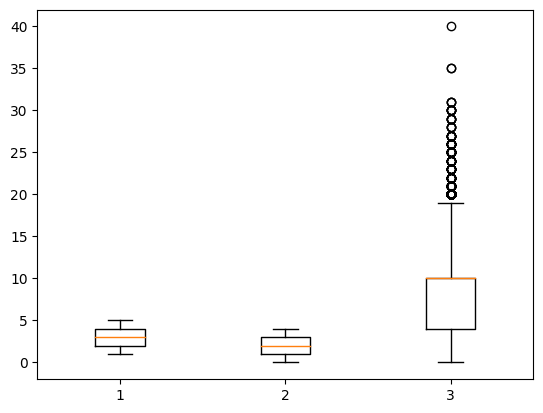

In [17]:
#Extract data and convert them into Pandas for visualization
converted_data = pull2[numeric_features].toPandas()

spotted_data = pull2[numeric_features[2:5]].toPandas()
figure_subset = plt.boxplot(spotted_data)
#Dr.Farag, lecture 6 and 7 Data engineering

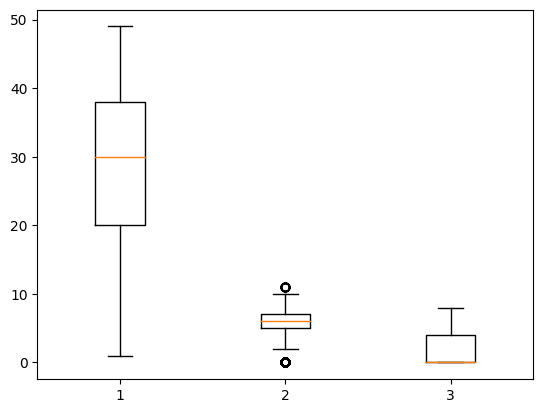

In [18]:
#
spotted_data = pull2[numeric_features[5:8]].toPandas()
figure_subset = plt.boxplot(spotted_data)

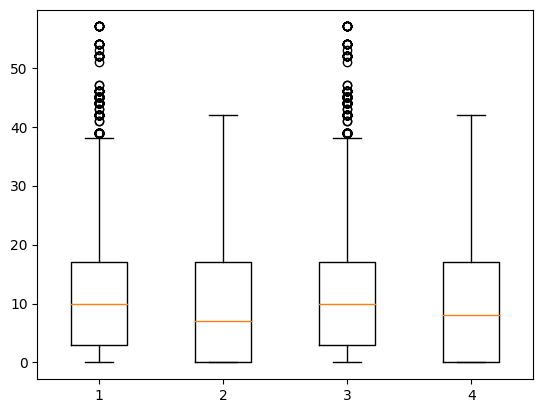

In [19]:

spotted_data = pull2[numeric_features[8:12]].toPandas()
figure_subset = plt.boxplot(spotted_data)

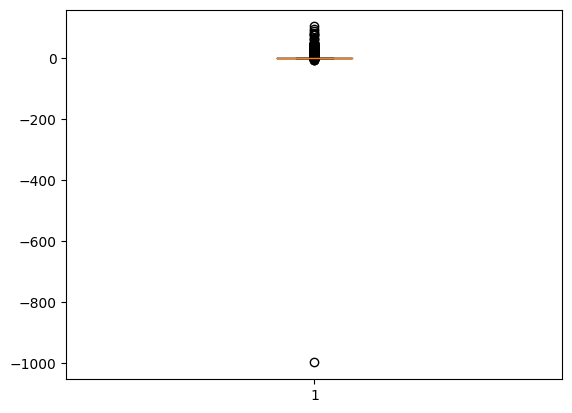

In [27]:

spotted_data = pull2[numeric_features[12:13]].toPandas()
figure_subset = plt.boxplot(spotted_data)

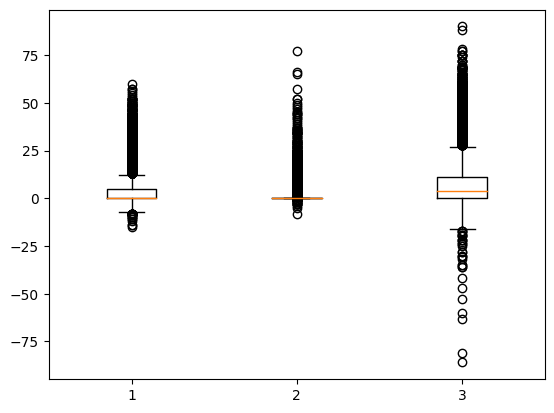

In [28]:

spotted_data = pull2[numeric_features[13:]].toPandas()
figure_subset = plt.boxplot(spotted_data)

### NOTE: Although the box plot is useful in finding out the outliers in the data, it seems not ideal to drop these outliers. for example, the `PlayResult` has a very high number of outliers but that is due to the type of play that was made. If the play was punt or kickoff, the `PlayResult` would be significantly higher than play types in which the play involved pass. This makes the kickoff or punt play types to result in outlier values. We cannot just drop these kinds of columns or rows just because there are outliers. These are meaningful data that can be used to predict the `PlayResult` in special play types. Similar logic applies to all of the columns here with high number of outliers.

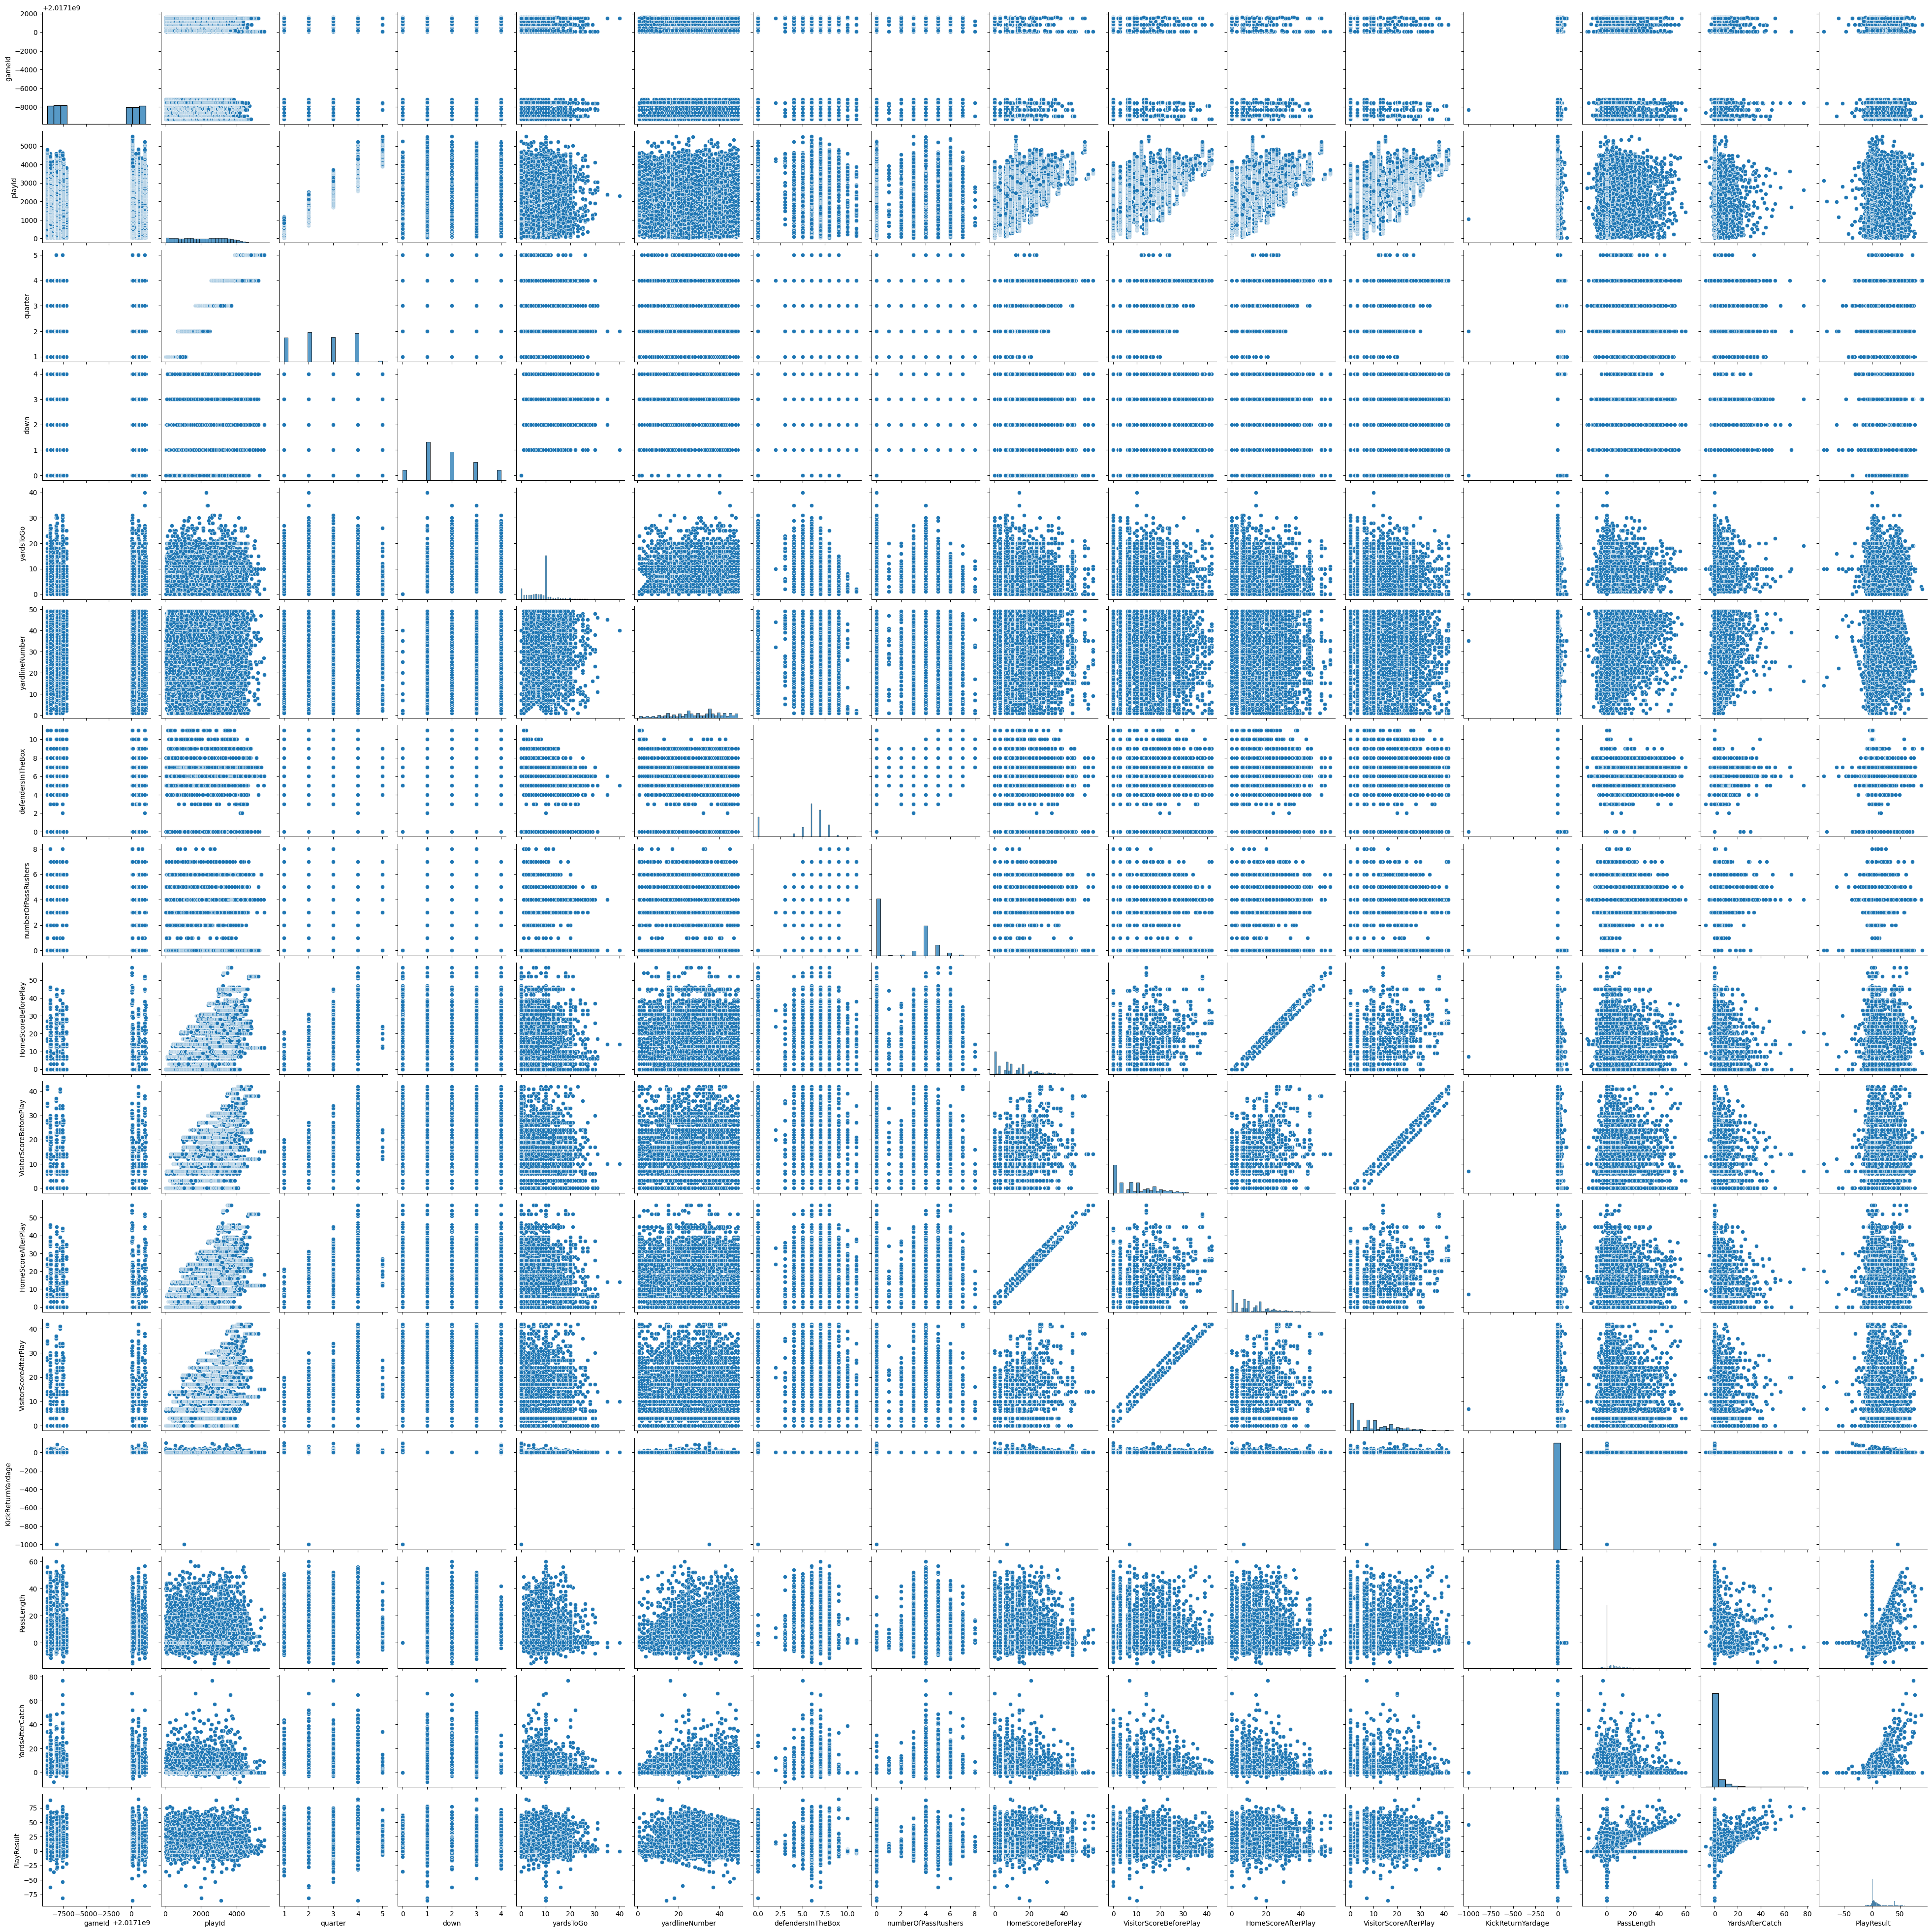

In [8]:
sb.pairplot(pull2.toPandas())

### Note: There are some values that have linear relationship that can be seen from the graph. These will be dropped in the following codes using the correlation function of the Spark. The plots for the `gameID` and `playID` are not really useful as they are unique identifiers and do not represent values that can predict PlayResult.

In [29]:
#Now to check for correlation, selecting all the columns that have numbers in it
3"quarter", "down", "yardsToGo", "yardlineNumber", "defendersInTheBox", 
                        "numberOfPassRushers", "HomeScoreBeforePlay", "VisitorScoreBeforePlay", "VisitorScoreAfterPlay",
                       "KickReturnYardage", "PassLength", "YardsAfterCatch", "PlayResult")

In [30]:
#Running the correlation and converting it to Pandas to see the values
correlation_matrix = cor_df.toPandas().corr()
print(correlation_matrix*100)

                           quarter        down   yardsToGo  yardlineNumber  \
quarter                 100.000000    1.007304    0.840201       -0.817952   
down                      1.007304  100.000000   12.980182        0.729021   
yardsToGo                 0.840201   12.980182  100.000000        6.025062   
yardlineNumber           -0.817952    0.729021    6.025062      100.000000   
defendersInTheBox         0.235601   -9.873622   29.102593       -3.740986   
numberOfPassRushers       1.765831   12.498052   19.533589        6.220902   
HomeScoreBeforePlay      62.907551   -4.157179   -3.911273       -0.590699   
VisitorScoreBeforePlay   68.766168   -3.344945   -2.306435        0.071816   
VisitorScoreAfterPlay    68.663406   -2.717573   -2.914272       -1.475643   
KickReturnYardage         0.092815   -2.408638   -6.858748        1.322584   
PassLength                2.086048    5.036500   13.481759        8.283851   
YardsAfterCatch          -0.153144    2.300683   10.494300      

In [383]:
#The VisitorScoreBeforePlay and VisitorScoreAfterPlay have high correlation of 99.6%. 
#Dropping the VisitorScoreBeforePlay column as we do not need highly correlated columns. 
#The rest seem to have not much correlation.
plays_df = pull2.drop("VisitorScoreBeforePlay")

In [384]:
#Since the isPenalty and isSTPPlay have both True or False values, these can be represented as Binary variable
#As such both columns are replace with 1s and 0s.
plays_df_binary = plays_df.withColumn('isPenalty', when(col('isPenalty') == "TRUE", 1).otherwise(0))

In [385]:
plays_df_binary = plays_df_binary.withColumn('isSTPlay', when(col('isSTPlay') == "TRUE", 1).otherwise(0))

In [386]:
#Checking to see that both columns have gotten correct Binary values
plays_df_binary.select("isPenalty").distinct().show()

+---------+
|isPenalty|
+---------+
|        1|
|        0|
+---------+



In [387]:
#Checking to see that both columns have gotten correct Binary values
plays_df_binary.select("isSTPlay").distinct().show()

+--------+
|isSTPlay|
+--------+
|       1|
|       0|
+--------+



In [390]:
#Dropping the Unique Identifiers as it cannot be used for ML training.
plays_df_binary = plays_df_binary.drop("gameID", "playID", "GameClock")

In [391]:
plays_df_binary.count()

14013

In [392]:
#Choosing all the string data types and running through the pipeline to represent in digits.
#These Stringtype columns are not ordinal but rather Nominal thus it requires One hot encoder.
# first part : transform the columns to numeric
stage_1 = StringIndexer(inputCol= 'possessionTeam', outputCol= 'possessionTeam_index')
stage_2 = StringIndexer(inputCol= 'yardlineSide', outputCol= 'yardlineSide_index')
stage_3 = StringIndexer(inputCol= 'offenseFormation', outputCol= 'offenseFormation_index')
stage_4 = StringIndexer(inputCol= 'personnel_offense', outputCol= 'personnel_offense_index')
stage_5 = StringIndexer(inputCol= 'personnel_defense', outputCol= 'personnel_defense_index')
stage_6 = StringIndexer(inputCol= 'SpecialTeamsPlayType', outputCol= 'SpecialTeamsPlayType_index')
stage_7 = StringIndexer(inputCol= 'PassResult', outputCol= 'PassResult_index')

# second part : one-hot encode the numeric columns
stage_8= OneHotEncoder(inputCols=["possessionTeam_index","yardlineSide_index",
                                  "offenseFormation_index","personnel_offense_index", 
                                  "personnel_defense_index", "SpecialTeamsPlayType_index", "PassResult_index"], 
                        outputCols=["possessionTeam_encoded","yardlineSide_encoded",
                                  "offenseFormation_encoded","personnel_offense_encoded", 
                                    "personnel_defense_encoded", "SpecialTeamsPlayType_encoded", "PassResult_encoded"])

# Setting up the pipelines to run
pipeline = Pipeline(stages=[stage_1, stage_2, stage_3, stage_4, stage_5, stage_6, stage_7, stage_8])

# fitting the pipeline model and transform the data as defined
pipeline_model = pipeline.fit(plays_df_binary)
df_encoded = pipeline_model.transform(plays_df_binary)
#Dr.Farag Lectures 6 and 7 notes.

In [393]:
#checking to see if the encoder worked correctly
df_encoded.select("possessionTeam_index", "yardlineSide_index","offenseFormation_index","personnel_offense_index", 
                  "personnel_defense_index", "SpecialTeamsPlayType_index", "PassResult_index", 
                  "possessionTeam_encoded", "yardlineSide_encoded", "offenseFormation_encoded",
                  "personnel_offense_encoded", "personnel_defense_encoded", "SpecialTeamsPlayType_encoded",
                  "PassResult_encoded" ).toPandas()

possessionTeam_index  yardlineSide_index  offenseFormation_index  \
0                       4.0                 8.0                     2.0   
1                       2.0                 2.0                     0.0   
2                       2.0                 2.0                     1.0   
3                       2.0                 2.0                     0.0   
4                       2.0                 2.0                     0.0   
...                     ...                 ...                     ...   
14008                  17.0                 7.0                     0.0   
14009                  17.0                 7.0                     3.0   
14010                  17.0                 7.0                     3.0   
14011                  17.0                 7.0                     3.0   
14012                  17.0                 7.0                     2.0   

       personnel_offense_index  personnel_defense_index  \
0                          1.0                      1.0   
1                          0.0                      0.0   
2                          0.0                      0.0   
3                          6.0                      8.0   
4                          2.0                      2.0   
...                        ...                      ...   
14008                      0.0                      7.0   
14009                      5.0                      3.0   
14010                      5.0                      3.0   
14011                      5.0                      3.0   
14012                      1.0                      1.0   

       SpecialTeamsPlayType_index  PassResult_index  \
0                             1.0               0.0   
1                             0.0               1.0   
2                             0.0               0.0   
3                             0.0               1.0   
4                             0.0               0.0   
...                           ...               ...   
14008                         0.0               1.0   
14009                         0.0               0.0   
14010                         0.0               0.0   
14011                         0.0               0.0   
14012                         4.0               0.0   

                                  possessionTeam_encoded  \
0      (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...   
1      (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2      (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3      (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4      (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                  ...   
14008  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
14009  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
14010  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
14011  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
14012  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                    yardlineSide_encoded  \
0      (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
1      (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2      (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3      (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4      (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                  ...   
14008  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...   
14009  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...   
14010  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...   
14011  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...   
14012  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...   

                       offenseFormation_encoded  \
0      (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
1      (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
2      (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
3      (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
4      (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [394]:
#Dropping no longer needed columns which is now represented by encoders
df_encoded = df_encoded.drop("possessionTeam", "yardlineSide",
                               "offenseFormation", "personnel_offense",
                               "personnel_defense", "SpecialTeamsPlayType", "PassResult",
                               "possessionTeam_index", "yardlineSide_index",
                               "offenseFormation_index", "personnel_offense_index",
                               "personnel_defense_index", "SpecialTeamsPlayType_index", "PassResult_index")

In [395]:
#Creating a list of columns now in preparationfor the vector assembler
feature_list = df_encoded.columns
print(feature_list)

['quarter', 'down', 'yardsToGo', 'yardlineNumber', 'defendersInTheBox', 'numberOfPassRushers', 'HomeScoreBeforePlay', 'HomeScoreAfterPlay', 'VisitorScoreAfterPlay', 'isPenalty', 'isSTPlay', 'KickReturnYardage', 'PassLength', 'YardsAfterCatch', 'PlayResult', 'possessionTeam_encoded', 'yardlineSide_encoded', 'offenseFormation_encoded', 'personnel_offense_encoded', 'personnel_defense_encoded', 'SpecialTeamsPlayType_encoded', 'PassResult_encoded']


In [396]:
#Assembling the columns with Vector Assembler
vector_assembler = VectorAssembler(
    inputCols=feature_list, 
    outputCol="vectorized_features")

df_with_assembled_features = vector_assembler.transform(df_encoded)

In [397]:
#Printing the a output to see if the vectorized_features column was added
df_with_assembled_features.show(3, vertical = True)

-RECORD 0--------------------------------------------
 quarter                      | 1                    
 down                         | 0                    
 yardsToGo                    | 0                    
 yardlineNumber               | 35                   
 defendersInTheBox            | 0                    
 numberOfPassRushers          | 0                    
 HomeScoreBeforePlay          | 0                    
 HomeScoreAfterPlay           | 0                    
 VisitorScoreAfterPlay        | 0                    
 isPenalty                    | 0                    
 isSTPlay                     | 1                    
 KickReturnYardage            | 23                   
 PassLength                   | 0                    
 YardsAfterCatch              | 0                    
 PlayResult                   | 42                   
 possessionTeam_encoded       | (31,[4],[1.0])       
 yardlineSide_encoded         | (31,[8],[1.0])       
 offenseFormation_encoded   

In [ ]:
standard_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
scaled_model = standard_scaler.fit(df_with_assembled_features)
df_with_scaled_features = scaled_model.transform(df_with_assembled_features)

df_with_scaled_features.select("classes","classes_encoded","features").distinct().toPandas()

In [398]:
#Standardizing the data in the vectorized_features so that some columns don't take too many weights
standard_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
scaled_model = standard_scaler.fit(df_with_assembled_features)
df_with_scaled_features = scaled_model.transform(df_with_assembled_features)

df_with_scaled_features.select("possessionTeam_encoded","features").distinct().toPandas()

possessionTeam_encoded  \
0      (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1      (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2      (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3      (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4      (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                  ...   
13966  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
13967  (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
13968  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
13969  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
13970  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                features  
0      (2.657108563566785, 1.7641369790490014, 2.5488...  
1      (3.5428114180890464, 0.0, 0.0, 2.8297379812671...  
2      (2.657108563566785, 0.0, 0.0, 0.16169931321526...  
3      (2.657108563566785, 2.646205468573502, 2.12400...  
4      (1.7714057090445232, 0.8820684895245007, 2.124...  
...                                                  ...  
13966  (3.5428114180890464, 0.0, 0.0, 2.8297379812671...  
13967  (2.657108563566785, 2.646205468573502, 0.42480...  
13968  (1.7714057090445232, 0.0, 0.0, 2.8297379812671...  
13969  (3.5428114180890464, 2.646205468573502, 1.4868...  
13970  (0.8857028545222616, 0.8820684895245007, 2.124...  

[13971 rows x 2 columns]

# Showing the sample output of the dataframe that was resulted from data scaling phase


In [399]:
#Showing the sample output of the dataframe that was resulted from data scaling phase
df_with_scaled_features.show(5, vertical =  True)

-RECORD 0--------------------------------------------
 quarter                      | 1                    
 down                         | 0                    
 yardsToGo                    | 0                    
 yardlineNumber               | 35                   
 defendersInTheBox            | 0                    
 numberOfPassRushers          | 0                    
 HomeScoreBeforePlay          | 0                    
 HomeScoreAfterPlay           | 0                    
 VisitorScoreAfterPlay        | 0                    
 isPenalty                    | 0                    
 isSTPlay                     | 1                    
 KickReturnYardage            | 23                   
 PassLength                   | 0                    
 YardsAfterCatch              | 0                    
 PlayResult                   | 42                   
 possessionTeam_encoded       | (31,[4],[1.0])       
 yardlineSide_encoded         | (31,[8],[1.0])       
 offenseFormation_encoded   